## Documents the module mctrue_functions.py

In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [4]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [5]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [8]:
idx = pd.IndexSlice

#### IC

In [9]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [10]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.graphics_reco import plot_hits3d
from tics.graphics_reco import plot_hits3d_and_true_extrema
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

#### NetFlex

In [11]:
from nextflex.core import Setup

In [12]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits
from nextflex.mctrue_functions import get_true_extrema
from nextflex.mctrue_functions import get_particle_ids_from_mchits
from nextflex.mctrue_functions import get_hit_ids_from_mchits

### Input data

In [13]:
FDATA = os.environ['FLEXDATA']

### test file

In [14]:
testFilebb      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.0.next.h5')
testFile1e      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.e-.ACTIVE.1000.next.h5')


### Functions

#### Monte Carlo Particles
- Nexus returns a DataFrame describing Monte Carlo Particles, with:

columns = ('particle_name', 'primary', 'mother_id',
           'initial_x', 'initial_y', 'initial_z', 'initial_t',
           'final_x', 'final_y', 'final_z', 'final_t',
           'initial_volume', 'final_volume', 'initial_momentum_x',
           'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x',
           'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length',
           'creator_proc', 'final_proc')
           
and:

index = ('event_id', 'particle_id')

- In NextFlex, the DataFrame is wrapped in an object of type McParticles (the purpose is to give a type to the object)

@dataclass
class McParticles():

    """
    Wrapper data class to give a type to the DataFrame
    representing a collection of particles and events
    with indexes running over particle_id and event_id

    """
    df      : DataFrame
    
***

- Function **get_mc_particles** return an object of type McParticles:

***
def get_mc_particles(file_name : str)->McParticles:

    """
    Return a McParticles object

    """
***

- Primary particles can be obtained with function **get_mc_primary_particles**

***
def get_mc_primary_particles(mc : McParticles)->McParticles:

    """
    Return primary particles

    """
***

- Particles can be selected with function **select_mc_particles**:

***
select_mc_particles(mc : McParticles,
                        event_slice : slice, particle_slice : slice,
                        columns : Columns = None)->Union[McParticles,
                                                         pd.Series,
                                                         pd.DataFrame]:
                                                         
    """
    The slice type is of the form slice(start, stop, step).
    Notice that slice(stop) is valid and slice(start, stop) is also valid
    Very importantly, notice that in pandas, the slicing
    follows a different convention than in python
    (which is very convenient), e.g, the slice includes start and stop

    If columns are not selected, the result of the operation is
    a McParticles object, otherwise a
    Series or DataFrame obtained by the column selection.

    """
***

##### Example: for bb0nu

In [15]:
mcParticlesbb = get_mc_particles(testFilebb)

In [16]:
mcParticlesbb.df.head()

particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
0        1                      e-     True          0 -269.933502   
         2                      e-     True          0 -269.933502   
         58268873               e-    False          2 -255.551224   
         89243466               e-    False          1 -273.232025   
         105688967           gamma    False          1 -285.643219   

                       initial_y   initial_z  initial_t     final_x  \
event_id particle_id                                                  
0        1           -240.895767  725.168030   0.000000 -273.207062   
         2           -240.895767  725.168030   0.000000 -261.039703   
         58268873    -223.139282  798.507751   0.389063 -255.514328   
         89243466    -240.705490  722.708618   0.014599 -273.400360   
         105688967   -247.731064  719.493469   0.097019 -285.658417   

                         final_y     final_z  ...  initial_momentum_x  \
event_id particle_id                          ...                       
0        1           -255.572342  724.871460  ...           -1.230723   
         2           -230.863617  792.874023  ...            0.323464   
         58268873    -223.028610  798.619751  ...            0.029650   
         89243466    -240.725677  722.638245  ...            0.099138   
         105688967   -247.798508  719.528198  ...           -0.000637   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
0        1                     0.196183          -0.760573               0.0   
         2                    -0.309306           1.809687               0.0   
         58268873              0.110097           0.185897               0.0   
         89243466              0.156985          -0.159078              -0.0   
         105688967            -0.002823           0.001454              -0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
0        1                        -0.0              -0.0    1.035855   
         2                        -0.0               0.0    1.421975   
         58268873                 -0.0               0.0    0.044589   
         89243466                 -0.0               0.0    0.055480   
         105688967                -0.0               0.0    0.003239   

                          length  creator_proc     final_proc  
event_id particle_id                                           
0        1             89.427818          none  Scintillation  
         2            139.282562          none  Scintillation  
         58268873       1.045491         eIoni  Scintillation  
         89243466       1.270810         eIoni  Scintillation  
         105688967      0.077368         eBrem           phot  

[5 rows x 23 columns]

In [17]:
mcPrimaryParticlesbb = get_mc_primary_particles(mcParticlesbb)
mcPrimaryParticlesbb.df

particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
0        1                      e-     True          0 -269.933502   
         2                      e-     True          0 -269.933502   
1        1                      e-     True          0  165.188828   
         2                      e-     True          0  165.188828   
2        1                      e-     True          0  158.634872   
         2                      e-     True          0  158.634872   
3        1                      e-     True          0  361.181091   
         2                      e-     True          0  361.181091   

                       initial_y   initial_z  initial_t     final_x  \
event_id particle_id                                                  
0        1           -240.895767  725.168030        0.0 -273.207062   
         2           -240.895767  725.168030        0.0 -261.039703   
1        1           -269.694000  276.376678        0.0  142.678940   
         2           -269.694000  276.376678        0.0  193.813828   
2        1           -419.372192  842.490967        0.0  184.076187   
         2           -419.372192  842.490967        0.0  119.082611   
3        1             97.745796  977.284607        0.0  378.840088   
         2             97.745796  977.284607        0.0  358.945526   

                         final_y     final_z  ...  initial_momentum_x  \
event_id particle_id                          ...                       
0        1           -255.572342  724.871460  ...           -1.230723   
         2           -230.863617  792.874023  ...            0.323464   
1        1           -234.377289  313.767792  ...           -0.620946   
         2           -268.276672  269.610596  ...            0.868705   
2        1           -425.637848  830.014221  ...            0.955685   
         2           -456.185028  827.313965  ...            0.479969   
3        1             95.132118  982.473083  ...           -1.254571   
         2             83.303543  984.803406  ...            0.323321   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
0        1                     0.196183          -0.760573               0.0   
         2                    -0.309306           1.809687               0.0   
1        1                     1.605168          -1.176261               0.0   
         2                     0.862397          -0.136560               0.0   
2        1                     0.333815           0.421589              -0.0   
         2                     2.063274           0.635943              -0.0   
3        1                     1.780896           0.615342               0.0   
         2                     0.901276           0.407179              -0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
0        1                        -0.0              -0.0    1.035855   
         2                        -0.0               0.0    1.421975   
1        1                         0.0              -0.0    1.635358   
         2                         0.0              -0.0    0.822472   
2        1                        -0.0              -0.0    0.698804   
         2                         0.0               0.0    1.759026   
3        1                        -0.0              -0.0    1.809627   
         2                         0.0               0.0    0.648203   

                          length  creator_proc     final_proc  
event_id particle_id                                           
0        1             89.427818          none  Scintillation  
         2            139.282562          none  Scintillation  
1        1            146.873718          none  Scintillation  
         2             75.891449    

##### Alternatively we can also do (for event_id = 0, for example):

In [18]:
mcPrim = select_mc_particles(mcPrimaryParticlesbb,
                      event_slice=slice(0,0), particle_slice=slice(1,2))


In [19]:
mcPrim.df

particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
0        1                      e-     True          0 -269.933502   
         2                      e-     True          0 -269.933502   

                       initial_y  initial_z  initial_t     final_x  \
event_id particle_id                                                 
0        1           -240.895767  725.16803        0.0 -273.207062   
         2           -240.895767  725.16803        0.0 -261.039703   

                         final_y     final_z  ...  initial_momentum_x  \
event_id particle_id                          ...                       
0        1           -255.572342  724.871460  ...           -1.230723   
         2           -230.863617  792.874023  ...            0.323464   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
0        1                     0.196183          -0.760573               0.0   
         2                    -0.309306           1.809687               0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
0        1                        -0.0              -0.0    1.035855   
         2                        -0.0               0.0    1.421975   

                          length  creator_proc     final_proc  
event_id particle_id                                           
0        1             89.427818          none  Scintillation  
         2            139.282562          none  Scintillation  

[2 rows x 23 columns]

#### McHits
- The McHits object is a table of "McTrue" hits (x,y,z,time, energy, label) indexed by event_id, particle_id and hit_id.

***
def get_mc_hits(file_name : str)->McHits:

    """
    Return a McHits object

    """

@dataclass\
class McHits:

    """
    Wrapper data class to give a type to the DataFrame
    representing a collection of monte carlo hits

    """
    df      : DataFrame


##### For a bbonu file

In [20]:
mcHits_bb = get_mc_hits(testFilebb)
mcHits_bb

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [21]:
mcHits_bb.df

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
3        83631883    77      361.853577   76.278801  991.085022  0.180530   
                     78      361.854279   76.278984  991.085205  0.180554   
                     79      361.854858   76.279205  991.085327  0.180574   
                     80      361.854950   76.279205  991.085815  0.180591   
                     81      361.854919   76.279099  991.086670  0.180629   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
3        83631883    77      0.000109  ACTIVE  
                     78      0.000363  ACTIVE  
                     79      0.000117  ACTIVE  
                     80      0.000899  ACTIVE  
                     81      0.001552  ACTIVE  

[2319 rows x 6 columns]

##### The event list is accesible via method event_list() 

In [22]:
mcHits_bb.event_list()

array([0, 1, 2, 3])

##### And the subyacent DataFrame via the attribute df

In [23]:
mcbb = mcHits_bb.df

##### or a 1e file

In [24]:
mcHits_1e = get_mc_hits(testFile1e)
mcHits_1e

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [25]:
mcHits_1e.df

x           y           z      time  \
event_id particle_id hit_id                                                 
5000     1           0      -459.471741   35.686749  680.406738  0.003376   
                     1      -460.011810   36.272388  679.806702  0.006753   
                     2      -460.630341   36.872669  679.305908  0.010129   
                     3      -461.301666   37.448700  678.840576  0.013514   
                     4      -461.951935   38.031681  678.373108  0.016870   
...                                 ...         ...         ...       ...   
5004     107284662   105    -108.350067  197.361862  823.132751  0.361198   
                     106    -108.351059  197.362000  823.133057  0.361227   
                     107    -108.352043  197.362106  823.133240  0.361256   
                     108    -108.353806  197.362274  823.133545  0.361308   
                     109    -108.353615  197.362976  823.132996  0.361349   

                               energy   label  
event_id particle_id hit_id                    
5000     1           0       0.009271  ACTIVE  
                     1       0.006503  ACTIVE  
                     2       0.003626  ACTIVE  
                     3       0.007412  ACTIVE  
                     4       0.009619  ACTIVE  
...                               ...     ...  
5004     107284662   105     0.000453  ACTIVE  
                     106     0.000188  ACTIVE  
                     107     0.000017  ACTIVE  
                     108     0.001673  ACTIVE  
                     109     0.001821  ACTIVE  

[2226 rows x 6 columns]

In [26]:
mcHits_1e.event_list()

array([5000, 5001, 5002, 5003, 5004])

In [27]:
mc1e = mcHits_1e.df

#### Selection function

***
def select_mc_hits(mc : McHits,
                        event_slice    : slice,
                        particle_slice : slice,
                        hit_slice      : slice,
                        columns        : Columns = None)->Union[McHits,
                                                                pd.Series,
                                                                pd.DataFrame]:
                                                                
    """
    The slice type is of the form slice(start, stop, step).
    Notice that slice(stop) is valid and slice(start, stop) is also valid
    Very importantly, notice that in pandas, the slicing
    follows a different convention than in python
    (which is very convenient), e.g, the slice includes start and stop

    If columns are not selected, the result of the operation is
    a McParticles object, otherwise a
    Series or DataFrame obtained by the column selection.
***


#### True extremA
- The definition of true extreme depends on whether the event is bb0nu or 1e.
    - For bbonu, the extrema are the last hit of each electron (particle 1 and particle 2)
    - For 1e the extremes are first and last hit of particle 1.
- Since hits are time-ordered one can use time to define what is first and last hits.

***
def get_true_extrema(mc         : McHits,
                      event_id   : int,
                      event_type : str = "bb0nu")->EventTrueExtrema:
                      
    """
    Returns the extrema of an event.
    If event_type is bb0nu the extrema are computed
    as the last hits of main primaries (1 and 2)
    If event_type is 1e, the extrema are computed as
    the first and last hit of track 1 (main electron)

    """

@dataclass\
class EventTrueExtrema:

    """
    Wrapper data class to give a type to the DataFrame
    representing a collection of hits (add time and label)

    """
    df       : DataFrame
    event_id : int

    def __post_init__(self):
        """
        The field columns speciy and thus documents the
        columns expected in the data frame

        """
        self.columns : Tuple[str] = ('x', 'y', 'z',
                                     'time', 'energy', 'label')

***

##### Select event 0 in the bb0nu file

In [28]:
mCbb_evt = select_mc_hits(mcHits_bb,
                        event_slice    = slice(0,0),
                        particle_slice = slice(None,None),
                        hit_slice      = slice(None,None))

In [29]:
mCbb_evt

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [30]:
mcbb_evt = mCbb_evt.df
mcbb_evt

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
         105872151   1      -285.659393 -247.800232  719.528992  0.097352   
         105872152   0      -285.658569 -247.798447  719.528198  0.097295   
         105872153   0      -285.658447 -247.798492  719.528198  0.097279   
         105872154   0      -285.658417 -247.798584  719.528198  0.097295   
         105872155   0      -285.658478 -247.798523  719.528259  0.097302   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
         105872151   1       0.002498  ACTIVE  
         105872152   0       0.000473  ACTIVE  
         105872153   0       0.000068  ACTIVE  
         105872154   0       0.000047  ACTIVE  
         105872155   0       0.000021  ACTIVE  

[549 rows x 6 columns]

##### The function implement the selection of a DF using slices

In [31]:
mcbb_evt2 = mcbb.loc[(slice(0,0), slice(None,None), slice(None,None)), :]

In [32]:
mcbb_evt2 

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
         105872151   1      -285.659393 -247.800232  719.528992  0.097352   
         105872152   0      -285.658569 -247.798447  719.528198  0.097295   
         105872153   0      -285.658447 -247.798492  719.528198  0.097279   
         105872154   0      -285.658417 -247.798584  719.528198  0.097295   
         105872155   0      -285.658478 -247.798523  719.528259  0.097302   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
         105872151   1       0.002498  ACTIVE  
         105872152   0       0.000473  ACTIVE  
         105872153   0       0.000068  ACTIVE  
         105872154   0       0.000047  ACTIVE  
         105872155   0       0.000021  ACTIVE  

[549 rows x 6 columns]

##### Select p1

In [33]:
mcbb_evt_p1 = mcbb.loc[(slice(0,0), slice(1,1), slice(None,None)), :]
mcbb_evt_p1

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
                     167    -273.206543 -255.572403  724.871521  0.348812   
                     168    -273.206848 -255.572388  724.871704  0.348827   
                     169    -273.207123 -255.572449  724.871887  0.348840   
                     170    -273.207031 -255.572357  724.871948  0.348848   
                     171    -273.207062 -255.572342  724.871460  0.348872   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
                     167     0.000054  ACTIVE  
                     168     0.000060  ACTIVE  
                     169     0.000604  ACTIVE  
                     170     0.000030  ACTIVE  
                     171     0.001073  ACTIVE  

[172 rows x 6 columns]

In [34]:
times_bb_p1 = mcbb_evt_p1.time

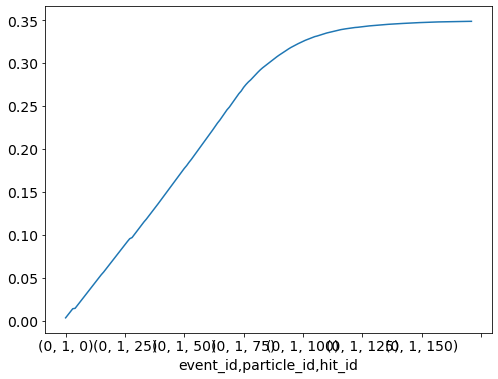

In [35]:
_ = times_bb_p1.plot()

##### Last hit of p1 is the hit with larger time

In [36]:
np.max(times_bb_p1)

0.34887227

##### Particle 2

In [37]:
mcbb_evt_p2 = mcbb.loc[(slice(0,0), slice(2,2), slice(None,None)), :]
mcbb_evt_p2

x           y           z      time  \
event_id particle_id hit_id                                                 
0        2           0      -269.774200 -241.066391  726.139587  0.003456   
                     1      -269.620819 -241.162506  727.120544  0.006907   
                     2      -269.476990 -241.136002  728.105835  0.010353   
                     3      -269.321198 -241.076401  729.089966  0.013808   
                     4      -268.974609 -240.957947  730.017883  0.017262   
...                                 ...         ...         ...       ...   
                     232    -261.045044 -230.865311  792.874207  0.523255   
                     233    -261.040497 -230.861237  792.875977  0.523395   
                     234    -261.040619 -230.861526  792.875183  0.523420   
                     235    -261.040161 -230.861877  792.874268  0.523449   
                     236    -261.039703 -230.863617  792.874023  0.523512   

                               energy   label  
event_id particle_id hit_id                    
0        2           0       0.004999  ACTIVE  
                     1       0.005551  ACTIVE  
                     2       0.007877  ACTIVE  
                     3       0.005921  ACTIVE  
                     4       0.021864  ACTIVE  
...                               ...     ...  
                     232     0.000029  ACTIVE  
                     233     0.002607  ACTIVE  
                     234     0.000031  ACTIVE  
                     235     0.000735  ACTIVE  
                     236     0.002869  ACTIVE  

[237 rows x 6 columns]

In [38]:
times_bb_p2 = mcbb_evt_p2.time

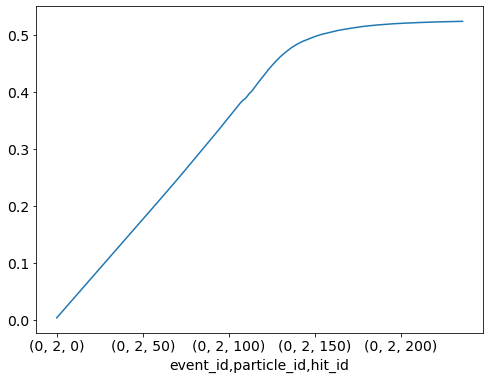

In [39]:
times_bb_p2.plot()

##### Last hit of particle 2

In [40]:
np.max(times_bb_p2)

0.52351236

##### Single electron

In [41]:
mc1e_evt = mc1e.loc[(slice(5000,5000), slice(None,None), slice(None,None)), :]

In [42]:
mc1e_evt

x          y           z      time  \
event_id particle_id hit_id                                                
5000     1           0      -459.471741  35.686749  680.406738  0.003376   
                     1      -460.011810  36.272388  679.806702  0.006753   
                     2      -460.630341  36.872669  679.305908  0.010129   
                     3      -461.301666  37.448700  678.840576  0.013514   
                     4      -461.951935  38.031681  678.373108  0.016870   
...                                 ...        ...         ...       ...   
                     75     -483.115021  92.394600  661.419922  0.255769   
                     76     -483.195190  92.482056  661.471008  0.256210   
                     77     -483.206512  92.495033  661.478333  0.256274   
                     78     -483.223602  92.511650  661.490112  0.256365   
                     79     -483.224091  92.512100  661.490417  0.256367   

                               energy   label  
event_id particle_id hit_id                    
5000     1           0       0.009271  ACTIVE  
                     1       0.006503  ACTIVE  
                     2       0.003626  ACTIVE  
                     3       0.007412  ACTIVE  
                     4       0.009619  ACTIVE  
...                               ...     ...  
                     75      0.002484  ACTIVE  
                     76      0.000117  ACTIVE  
                     77      0.000056  ACTIVE  
                     78      0.000129  ACTIVE  
                     79      0.000006  ACTIVE  

[80 rows x 6 columns]

In [43]:
times1e = mc1e_evt.time

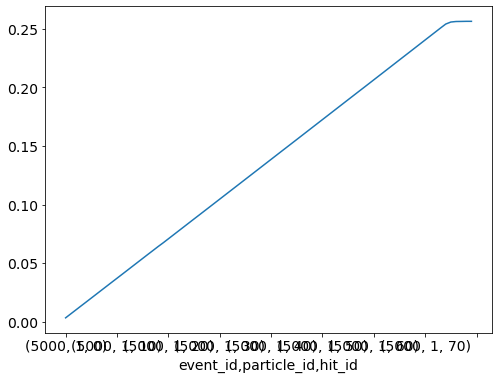

In [44]:
times1e.plot()

##### First and last hit

In [45]:
np.min(times1e)

0.0033755803

In [46]:
np.max(times1e)

0.25636715

##### Get true extremes from function (bb)

In [49]:
tebb = get_true_extrema(mcHits_bb, event_id= 0, event_type = "bb0nu").df

In [50]:
tebb

,x,y,z,time,energy,label
0,-273.207062,-255.572342,724.871460,0.348872,0.001073,ACTIVE
1,-261.039703,-230.863617,792.874023,0.523512,0.002869,ACTIVE


In [51]:
tebb.time

0    0.348872
1    0.523512
Name: time, dtype: float32

In [52]:
np.allclose(tebb.time[0], np.max(times_bb_p1))

True

In [53]:
np.allclose(tebb.time[1], np.max(times_bb_p2))

True

##### For 1e

In [54]:
te1e = get_true_extrema(mcHits_1e, event_id= 5000, event_type = "1e").df

In [55]:
te1e

,x,y,z,time,energy,label
0,-459.471741,35.686749,680.406738,0.003376,0.009271,ACTIVE
1,-483.224091,92.512100,661.490417,0.256367,0.000006,ACTIVE


In [56]:
te1e.time

0    0.003376
1    0.256367
Name: time, dtype: float32

In [57]:
np.allclose(te1e.time[0], np.min(times1e))

True

In [58]:
np.allclose(te1e.time[1], np.max(times1e))

True

#### primary hits

In [59]:
mcphits = get_event_hits_from_mchits(mcHits_bb, event_id=0, particle_type='primary')

In [60]:
mcphits.df

,x,y,z,energy
0,-270.746246,-240.824417,724.598206,0.005752
1,-271.566711,-240.745667,724.041504,0.006912
2,-272.361237,-240.716476,723.438293,0.025096
3,-273.137329,-240.716278,722.811584,0.007589
4,-273.232025,-240.705490,722.708618,0.000587
...,...,...,...,...
404,-261.045044,-230.865311,792.874207,0.000029
405,-261.040497,-230.861237,792.875977,0.002607
406,-261.040619,-230.861526,792.875183,0.000031
407,-261.040161,-230.861877,792.874268,0.000735


In [61]:
mcphits.df.energy.sum()

2.3545222

In [62]:
mcphits

<EventHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy')
        

In [63]:
mcphits1e = get_event_hits_from_mchits(mcHits_1e, event_id=5000, particle_type='primary')

In [64]:
mcphits1e.df

,x,y,z,energy
0,-459.471741,35.686749,680.406738,0.009271
1,-460.011810,36.272388,679.806702,0.006503
2,-460.630341,36.872669,679.305908,0.003626
3,-461.301666,37.448700,678.840576,0.007412
4,-461.951935,38.031681,678.373108,0.009619
...,...,...,...,...
75,-483.115021,92.394600,661.419922,0.002484
76,-483.195190,92.482056,661.471008,0.000117
77,-483.206512,92.495033,661.478333,0.000056
78,-483.223602,92.511650,661.490112,0.000129


#### all hits

In [65]:
mchits = get_event_hits_from_mchits(mcHits_bb, event_id=0, particle_type='all')

In [66]:
mchits

<EventHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy')
        

In [67]:
mchits.df.energy.sum()

2.4578302

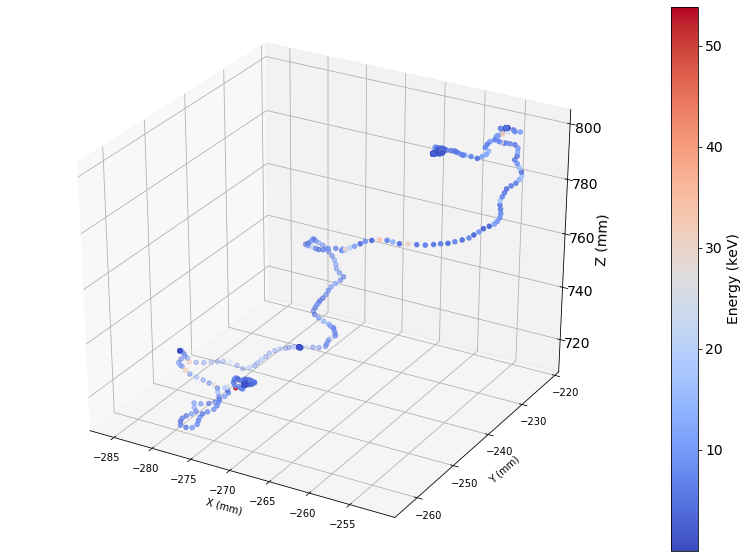

In [68]:
plot_hits3d(mchits.df, autorange = True, figsize   = (14,10))

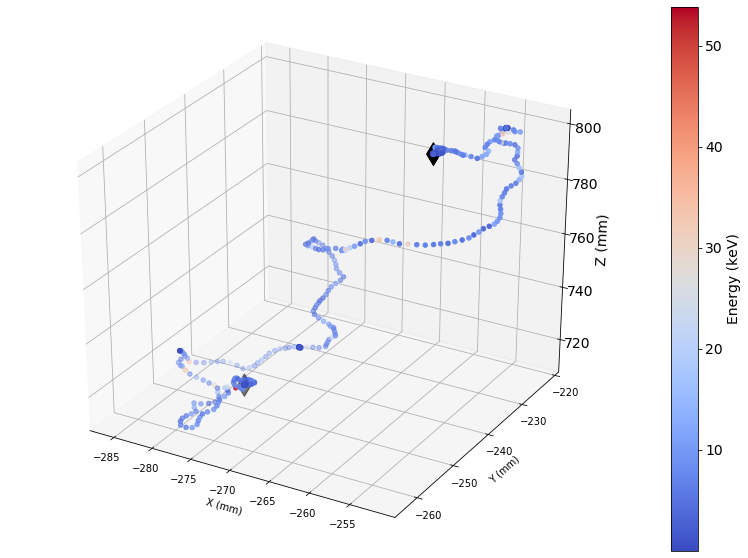

In [69]:
plot_hits3d_and_true_extrema(mchits.df, tebb, autorange = True, figsize   = (14,10))

In [70]:
mchits1e = get_event_hits_from_mchits(mcHits_1e, event_id=5000, particle_type='all')

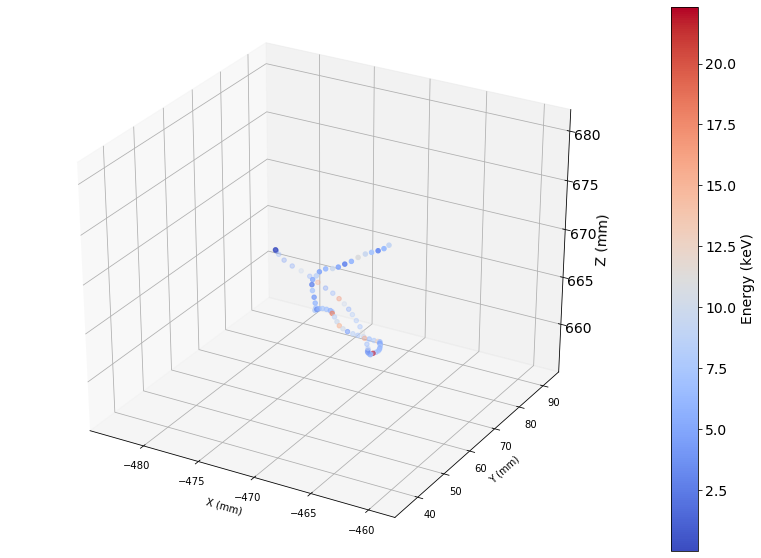

In [71]:
plot_hits3d(mchits1e.df, autorange = True, figsize   = (14,10))

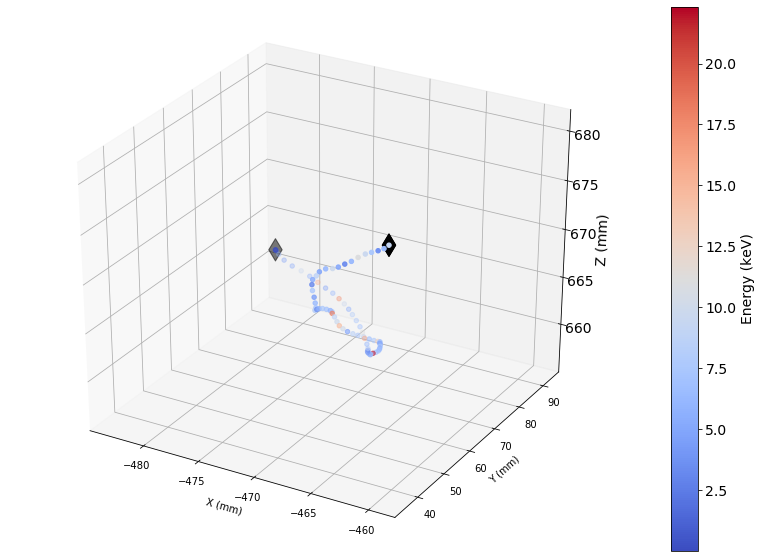

In [72]:
plot_hits3d_and_true_extrema(mchits1e.df, te1e, autorange = True, figsize   = (14,10))